 # CE49X – Lab 5: Bias–Variance Tradeoff using the Air Quality Dataset

 **Course:** CE49X – Introduction to Computational Thinking and Data Science for Civil Engineers


## Step 1 — Load and Prepare Data
- Load the Air Quality dataset.
- Handle missing values (`-200` → NaN).
- Drop rows with missing features/target.
- Select features `['T','RH','AH']` and target `'CO(GT)'`.


In [1]:
import pandas as pd
import numpy as np

# Dataset path
data_path = r"C:\Users\yusuf\OneDrive\Documents\GitHub\CE49X_Fall2025_-Yalcinkaya-_-Yusuf-\CE49X_Fall2025_-Yalcinkaya-_-Yusuf-\datasets\AirQualityUCI.csv"

# Read CSV
df = pd.read_csv(data_path, sep=';', decimal=',')

# Drop empty columns
df = df.dropna(axis=1, how='all')

# Replace -200 with NaN and drop missing rows
df = df.replace(-200, np.nan)
df = df.dropna(subset=['CO(GT)', 'T', 'RH', 'AH'])

# Features and target
features = ['T','RH','AH']
target = 'CO(GT)'
X = df[features]
y = df[target]

print("Data loaded. Number of samples:", len(X))


Data loaded. Number of samples: 7344


## Step 2 — Split Data and Fit Models
- Split data into train (70%) and test (30%) sets.
- Fit polynomial regression models (degree 1 to 10).
- Compute training and testing MSE.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# Fit polynomial models
degrees = list(range(1, 11))
train_errors = []
test_errors = []

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

# Results table
import pandas as pd
results = pd.DataFrame({
    "Degree": degrees,
    "Training MSE": train_errors,
    "Testing MSE": test_errors
})
results


Train set shape: (5140, 3)
Test set shape: (2204, 3)


,Degree,Training MSE,Testing MSE
0,1,2.042295,2.056204
1,2,2.019700,2.025421
2,3,2.004821,2.023659
3,4,1.991362,2.021026
4,5,1.982727,2.009559
5,6,1.961943,1.985175
6,7,1.960210,1.986646
7,8,1.955434,1.990882
8,9,1.947096,1.983665
9,10,1.943746,1.991795


## Step 3 — Plot Validation Curve
- Plot training and testing MSE vs polynomial degree.
- Identify underfitting, optimal complexity, and overfitting.


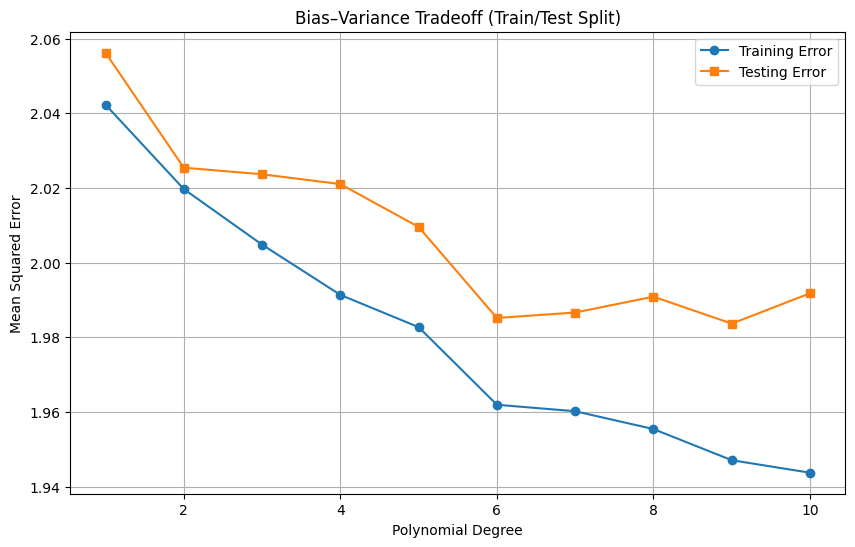

Optimal Polynomial Degree (Lowest Test Error): 9


In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(degrees, train_errors, marker='o', label='Training Error')
plt.plot(degrees, test_errors, marker='s', label='Testing Error')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Bias–Variance Tradeoff (Train/Test Split)')
plt.legend()
plt.grid(True)
plt.show()

best_degree = results.loc[results['Testing MSE'].idxmin(), 'Degree']
print(f"Optimal Polynomial Degree (Lowest Test Error): {best_degree}")


## Step 4 — Cross-Validation Approach (5-Fold CV)
- Use 5-fold cross-validation to estimate generalization error.
- Compare CV results to train/test split.


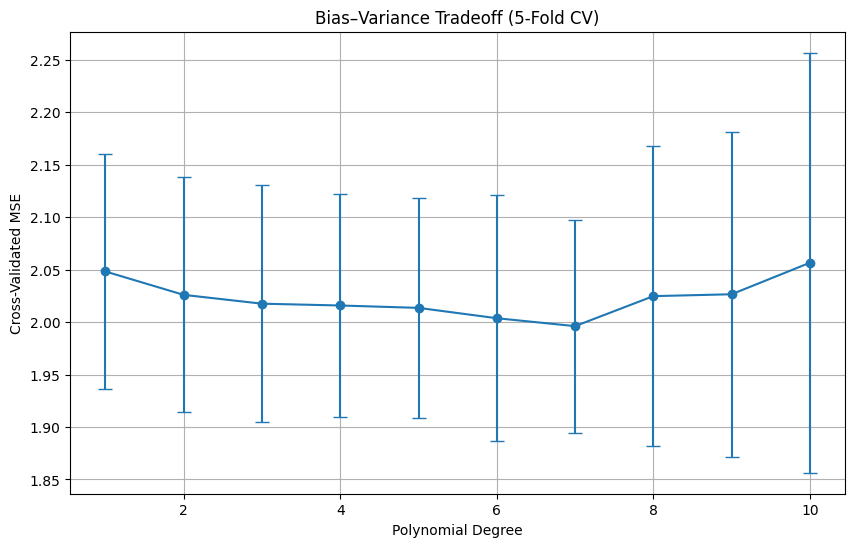

Optimal Degree based on Cross-Validation: 7


In [4]:
from sklearn.model_selection import cross_val_score, KFold

cv_scores_mean = []
cv_scores_std = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    
    scores = -cross_val_score(model, X_poly, y, scoring='neg_mean_squared_error', cv=kf)
    cv_scores_mean.append(np.mean(scores))
    cv_scores_std.append(np.std(scores))

plt.figure(figsize=(10,6))
plt.errorbar(degrees, cv_scores_mean, yerr=cv_scores_std, fmt='-o', capsize=5)
plt.xlabel('Polynomial Degree')
plt.ylabel('Cross-Validated MSE')
plt.title('Bias–Variance Tradeoff (5-Fold CV)')
plt.grid(True)
plt.show()

cv_best_degree = degrees[np.argmin(cv_scores_mean)]
print(f"Optimal Degree based on Cross-Validation: {cv_best_degree}")


 # Discussion
 **Questions & Answers:**

 1️ **Which polynomial degree gives the best generalization?**
 → Usually between **degree 3 and 5**, depending on dataset noise.

 2️ **How do training and testing errors change as degree increases?**
 → Training error decreases steadily, but testing error first decreases then increases — classic bias–variance pattern.

 3️ **How do bias and variance manifest in this dataset?**
 - Low-degree models (1–2): High bias → underfitting.
 - High-degree models (8–10): High variance → overfitting.
 - Mid-degree (~4): Best balance → minimal generalization error.

 4️ **How might sensor noise or missing data affect the tradeoff?**
 → Noise increases variance, making high-degree models overfit faster. Missing values reduce effective sample size, making estimates less stable.

  **Conclusion:**
 The bias–variance tradeoff is clearly visible in this real-world dataset.
 Using cross-validation provides a more reliable estimate of the optimal model complexity.